In [77]:
import re
import random
import pandas as pd
import hashlib

In [78]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [79]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Lost in a Good Book, Fforde",44.934262,8.986852,12.368365,5
Terraform Codebox,79.260695,1.617565,11.616002,49
Power BI,314.629870,9.534238,23.185334,33
Azure AD Authentication,325.110548,108.370183,179.730934,3
Pandas,362.355641,40.261738,95.519248,9
Azure Private DNS,467.160104,93.432021,245.987594,5
DAX,695.191103,77.243456,262.661170,9
Azure DevOps Pipelines,754.849049,75.484905,160.447564,10
CCH Axcess,809.810715,27.924507,68.610651,29
Azure Functions + PP365,987.339877,70.524277,123.548895,14


# Histogram

sum of ages: ~42244.18


<Axes: >

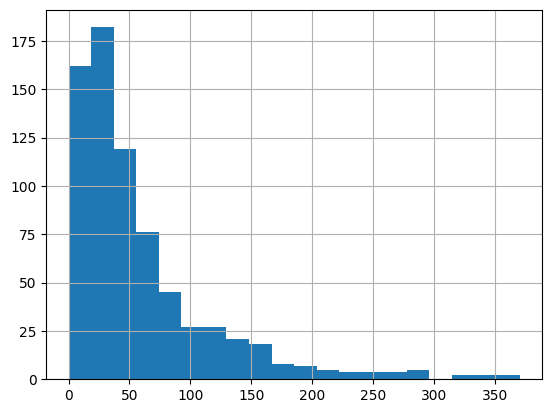

In [80]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~42244.18


<Axes: >

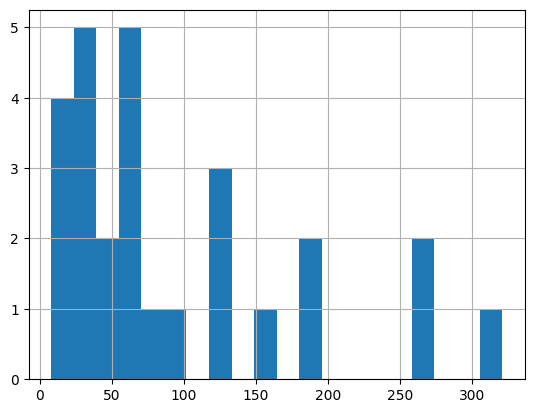

In [96]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='PowerShell Modules']['age'].hist(bins=20)

# Completely Random Shuffle

In [82]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [83]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [84]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [85]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [86]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [87]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [88]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [89]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [90]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [91]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [92]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 720
Total card age: 42244.18


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
0,Azure AD Authentication,"Role Assignment\nLinks a principal (user, grou...",f445b4bb29b65e4bfdc8ae15101622af,179.730934,108.370183,-179.730934,325.110548,0.385154,3,3,0,0,-179.730934
1,Azure AD Authentication,Service Principal Authentication Methods\nAuth...,551e14e36b831568933c1ffb27e349ba,85.340681,108.370183,-179.730934,325.110548,0.385154,3,3,1,0,-85.340681
2,Azure AD Authentication,Azure AD Roles vs Azure Resource Roles\nAzure ...,6c6c1200236d748fc352faaaf8856bff,60.038932,108.370183,-179.730934,325.110548,0.385154,3,3,2,0,-60.038932
8,Azure Private DNS,Registration-Enabled\nDefinition: A setting th...,6079fced3a7dad3dbe3ed78b06dbe58d,245.987594,93.432021,-245.987594,467.160104,0.038972,5,5,0,0,-245.987594
9,Azure Private DNS,CNAME Record (Canonical Name Record):\nDefinit...,920fdb4aa77118108f2222e804c8d4c2,126.525881,93.432021,-245.987594,467.160104,0.038972,5,5,1,0,-126.525881
10,Azure Private DNS,Dynamic DNS (DDNS)\nDefinition: A DNS service ...,6d48ffafbef701c139297cd7daeb9797,45.233024,93.432021,-245.987594,467.160104,0.038972,5,5,2,0,-45.233024
11,Azure Private DNS,Record Set\nDefinition: A collection of DNS re...,a31d365bc40c2fabb6aeaee702668d18,26.434911,93.432021,-245.987594,467.160104,0.038972,5,5,3,0,-26.434911
12,Azure Private DNS,Private DNS Zone:\nDefinition: A container wit...,d4c5b37ed1fd21ed80e5034b8cf5205e,22.978695,93.432021,-245.987594,467.160104,0.038972,5,5,4,0,-22.978695
3,"Lost in a Good Book, Fforde",Wisteria: A climbing flowering plant with frag...,41f99c38886a575deffe4cdb28b87571,12.368365,8.986852,-12.368365,44.934262,0.567236,5,5,0,0,-12.368365
4,"Lost in a Good Book, Fforde",Impresario: A manager or producer of theatrica...,4f8698634f04d91b6d1e02965ab303c3,10.599026,8.986852,-12.368365,44.934262,0.567236,5,5,1,0,-10.599026



## Random

In [93]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [ ]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
101,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,370.451673,85.953175,-370.451673,2664.548432,0.930044,31,31,0,0,-370.451673
121,Azure Compute Gallery,SAS Token (Shared Access Signature) – A tempor...,16543cefaf9d760fb4860bf0a6fcb4bb,361.802742,72.284938,-361.802742,2385.402965,0.639545,33,33,0,0,-361.802742
131,Asynchronous Python,Coroutine Object\nThe result of calling an asy...,877cc6e7d0264598007bf336b88f4c3e,335.163702,78.953813,-335.163702,2605.475843,0.100315,33,33,0,0,-335.163702
41,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,334.376695,89.543230,-334.376695,1074.518760,0.010597,12,12,0,0,-334.376695
81,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,321.105784,94.741500,-321.105784,2558.020509,0.874538,27,27,0,0,-321.105784
102,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,319.507760,85.953175,-370.451673,2664.548432,0.930044,31,31,1,0,-319.507760
211,JavaScript Concepts,Using Object.keys() with for...of Loop: The Ob...,06c15a040f743007e381b243ccc3d915,296.248959,61.685503,-296.248959,4132.928729,0.128007,67,67,0,0,-296.248959
61,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,292.677812,75.108107,-292.677812,1802.594573,0.184208,24,24,0,0,-292.677812
103,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,289.197317,85.953175,-370.451673,2664.548432,0.930044,31,31,2,0,-289.197317
201,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,283.025835,60.928944,-283.025835,3229.234049,0.920207,53,53,0,0,-283.025835


In [95]:
existing_cards['age'].mean()

58.672471390343546